# Evaluate single site simulation

This script generates key information on forest structure, composition, demography and biophysical characteristics on a single site simulation

# Import modules

In [13]:
import sys

#Path to the esm_tools.py script
sys.path.append('/glade/u/home/adamhb/Earth-System-Model-Tools/process_output')

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import functools
import cftime
import warnings
from matplotlib.dates import DateFormatter
import math
from datetime import datetime
import esm_tools
import esm_viz
import importlib
importlib.reload(esm_tools)
importlib.reload(esm_viz)

<module 'esm_viz' from '/glade/u/home/adamhb/Earth-System-Model-Tools/process_output/esm_viz.py'>

# Setup

In [15]:
save_processed_output = False
pft_names = ["pine","cedar","fir"]#,"shrub","oak"]
pft_colors = ['gold','darkorange','darkolivegreen','brown','springgreen']
n_pfts = len(pft_names)
years = list(range(1940, 1945))

case_name = "conifer-allom-090123_-17e2acb6a_FATES-55794e61"
inst_tag = "0007"

# Root path where case output lives
model_output_root = '/glade/scratch/adamhb/archive'
# Path to put processed output
processed_output_root = '/glade/scratch/adamhb/processed_output'
output_path_for_case = os.path.join(processed_output_root,case_name,inst_tag)

if save_processed_output == True:
        # Path to store processed output (figs, tables etc.)
        esm_tools.create_directory(output_path_for_case)

# Constants
s_per_yr = 31536000
s_per_day = 3600 * 24
m2_per_ha = 1e4
m2_per_km2 = 1e6
g_per_kg = 1000
mm_per_m = 1000
months_per_yr = 12
s_per_month = 3600 * 24 * 30.4

# History variables

In [16]:
# define the history variables to read in
fields = [
          #have on to import these dimensions
          'FATES_SEED_PROD_USTORY_SZ',
          'FATES_VEGC_AP',
          #patches and cohorts
          'FATES_NPATCHES',
          'FATES_PATCHAREA_AP','FATES_CANOPYAREA_AP',
          'FATES_NCOHORTS','FATES_NPATCH_AP',
          #structure
          #'FATES_LAI_AP',
          #density
          'FATES_NPLANT_PF',
          'FATES_NPLANT_SZAPPF',
          'FATES_NPLANT_SZPF',
          'FATES_NPLANT_ACPF',
          'FATES_NPLANT_CANOPY_SZPF',
          'FATES_NPLANT_USTORY_SZPF',
          #basal area
          'FATES_BASALAREA_SZPF',
          #crown_area
          'FATES_CANOPYCROWNAREA_PF',
          'FATES_CANOPYCROWNAREA_APPF',
          'FATES_CROWNAREA_APPF',
          #'FATES_CANOPYAREA_HT',
          #'FATES_CROWNAREA_CLLL',
          'FATES_CROWNAREA_PF',
          #biomass
          'FATES_VEGC_PF','FATES_VEGC_AP','FATES_VEGC_ABOVEGROUND','FATES_VEGC_ABOVEGROUND_SZPF',
          #growth
          #'FATES_DDBH_SZPF',
          #'FATES_DDBH_CANOPY_SZAP','FATES_DDBH_USTORY_SZAP',
          #mortality
          'FATES_MORTALITY_PF',
          #'FATES_MORTALITY_CANOPY_SZAP','FATES_MORTALITY_USTORY_SZAP',
          'FATES_MORTALITY_BACKGROUND_SZPF','FATES_MORTALITY_HYDRAULIC_SZPF','FATES_MORTALITY_CSTARV_SZPF',
          #'FATES_MORTALITY_IMPACT_SZPF',
          'FATES_MORTALITY_FIRE_SZPF','FATES_MORTALITY_CROWNSCORCH_SZPF',
          #'FATES_MORTALITY_CANOPY_SZ','FATES_MORTALITY_USTORY_SZ',
          'FATES_MORTALITY_SENESCENCE_SZPF',
          #seed production and recruitment
          #'FATES_SEED_PROD_USTORY_SZ','FATES_SEED_PROD_CANOPY_SZ',
          #'FATES_SEEDS_IN',
          'FATES_SEED_BANK',
          'FATES_SEEDBANK_PF',
          'FATES_SEED_ALLOC_SZPF',
          'FATES_RECRUITMENT_PF',
          #GPP and NPP
          #'FATES_GPP','FATES_GPP_SZPF',
          'FATES_NPP_PF','FATES_NPP_SZPF',
          'FATES_AUTORESP_SZPF','FATES_MAINTAR_SZPF',
          #physical environment
          #Light
          'FATES_LAISUN_Z_CLLL','FATES_LAISHA_Z_CLLL',
          'FATES_LAISUN_Z_CLLLPF','FATES_LAISHA_Z_CLLLPF',
          'FATES_PARSUN_Z_CLLLPF','FATES_PARSHA_Z_CLLLPF',
          'FATES_PARPROF_DIR_CLLL','FATES_PARPROF_DIF_CLLL',
          'FATES_PARPROF_DIF_CLLLPF','FATES_PARPROF_DIR_CLLLPF',
          #Litter
          'FATES_CWD_ABOVEGROUND_DC',
          'FATES_FUEL_AMOUNT',
          #CLM
          'QVEGT','QVEGE','QSOIL','TLAI','TBOT','RAIN','QBOT','Q2M',
          #'BTRAN',
          #H20
          'SMP',
          #allocation
          #'FATES_STOREC_CANOPY_SZPF','FATES_STOREC_USTORY_SZPF',
          #fire
          'FATES_BURNFRAC','FATES_IGNITIONS','FATES_FIRE_INTENSITY_BURNFRAC',
          'FATES_FUEL_BULKD','FATES_FUEL_SAV',
           'FATES_DISTURBANCE_RATE_FIRE',
          # 'FATES_FUEL_AMOUNT_AP',
          # 'FATES_FIRE_INTENSITY_BURNFRAC_AP',
          # 'FATES_BURNFRAC_AP',
           'FATES_FUEL_AMOUNT_APFC',
           'FATES_FUEL_AMOUNT',
           'FATES_FDI',
           'FATES_FIRE_INTENSITY',
           'FATES_FUELCONSUMED',
           'FATES_NESTEROV_INDEX',
           'FATES_MORTALITY_CROWNSCORCH_SZPF',
          # 'FATES_SCORCH_HEIGHT_APPF','FATES_FUEL_MEF',
           'FATES_FUEL_EFF_MOIST','FATES_FUEL_MOISTURE_FC','FATES_ROS'
          # 'FATES_MORTALITY_FIRE_CFLUX_PF'
          ]

# Load data

In [17]:
ds = esm_tools.load_fates_output_data(model_output_root=model_output_root,
                            case_name = case_name,
                            years = years,
                            fields = fields,
                            inst_tag = inst_tag)

-- your data have been read in -- 


# Analyze final year of simulation

In [18]:
final_year_string = str(years[-1]) + "-01-01"
print("final year start",final_year_string)
ds_final_year = ds.sel(time = slice(final_year_string,None))

final year start 1944-01-01


## AGB

In [19]:
print("Total AGB:",esm_tools.get_AGB(ds_final_year))

Total AGB: 5.893797397613525


AGB units: kg m-2


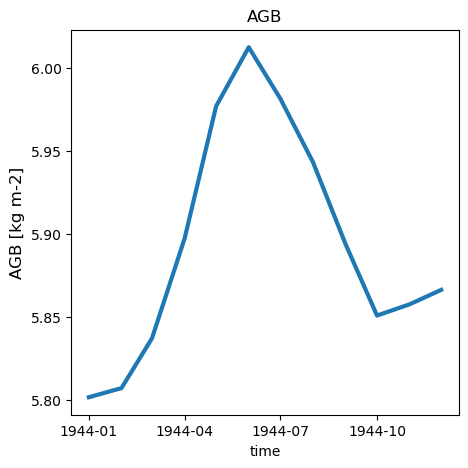

In [20]:
print("AGB units:",ds_final_year.FATES_VEGC_ABOVEGROUND.attrs['units'])

esm_viz.plot_array(ds_final_year.FATES_VEGC_ABOVEGROUND,
           xds = ds,
           n_pfts = n_pfts,
           title = "AGB",
           ylabel = "AGB [kg m-2]",
           output_path = output_path_for_case,
           conversion = 1,
           subplots = False,
           getData = False,
           dbh_min = None)

## Basal Area

In [21]:
print("Total basal area [m2 ha-1]:",np.sum(esm_tools.get_pft_level_basal_area(ds_final_year)))

Total basal area [m2 ha-1]: 31.5331


In [23]:
importlib.reload(esm_tools)
importlib.reload(esm_viz)

<module 'esm_viz' from '/glade/u/home/adamhb/Earth-System-Model-Tools/process_output/esm_viz.py'>

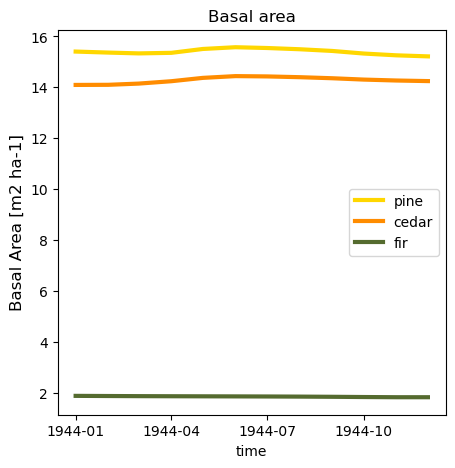

In [24]:
esm_viz.plot_array(ds_final_year.FATES_BASALAREA_SZPF,
           xds = ds_final_year,
           n_pfts = n_pfts,
           pft_colors = pft_colors,
           pft_names = pft_names,
           conversion = m2_per_ha,
           title = "Basal area",
           ylabel = "Basal Area [m2 ha-1]",
           output_path = output_path_for_case,
           subplots = False,
           getData = False,
           dbh_min = None)

### BA across size classes

In [26]:
importlib.reload(esm_tools)
importlib.reload(esm_viz)

<module 'esm_viz' from '/glade/u/home/adamhb/Earth-System-Model-Tools/process_output/esm_viz.py'>

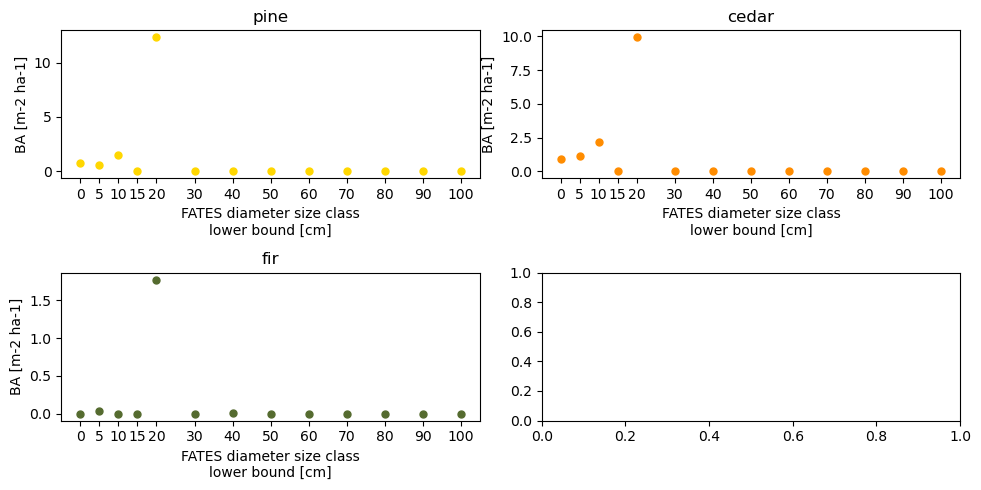

In [27]:
esm_viz.plot_size_class_distribution(ds_final_year,
                             n_pfts,
                             pft_colors = pft_colors,
                             pft_names = pft_names,
                             variable_type = "BA",
                             final_timestep = True,
                             specific_time_step = None,
                             conversion=m2_per_ha)

## Stem density

In [28]:
importlib.reload(esm_tools)
importlib.reload(esm_viz)

<module 'esm_viz' from '/glade/u/home/adamhb/Earth-System-Model-Tools/process_output/esm_viz.py'>

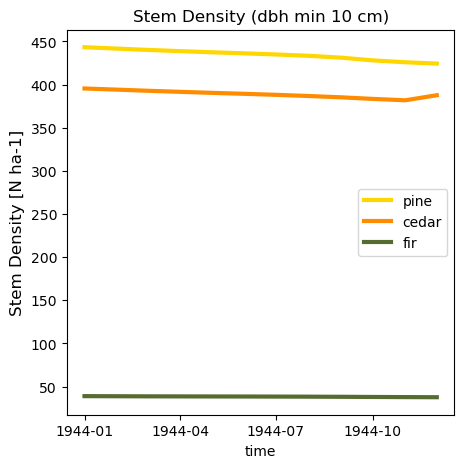

In [30]:
esm_viz.plot_array(ds_final_year.FATES_NPLANT_SZPF,
           xds = ds,
           n_pfts = n_pfts,
           pft_colors = pft_colors,
           pft_names = pft_names,
           title = "Stem Density" + " (dbh min " + str(10) + " cm)",
           ylabel = "Stem Density [N ha-1]",
           output_path = output_path_for_case,
           conversion = m2_per_ha,
           subplots = False,
           getData = False,
           dbh_min = 10)

### Stem density across size classes (dbh min = 10 cm)

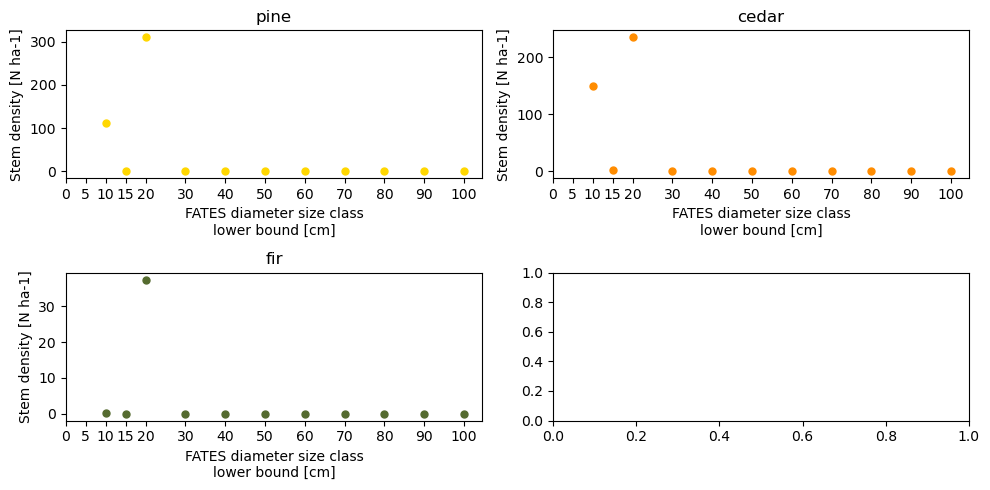

In [31]:
esm_viz.plot_size_class_distribution(ds_final_year,
                             n_pfts,
                             pft_colors = pft_colors,
                             pft_names = pft_names,
                             variable_type = "Stem density",
                             final_timestep = True,
                             specific_time_step = None,
                             conversion=m2_per_ha, dbh_min = 10)

## Crown area

### Canopy crown area

Text(0.5, 0, 'year')

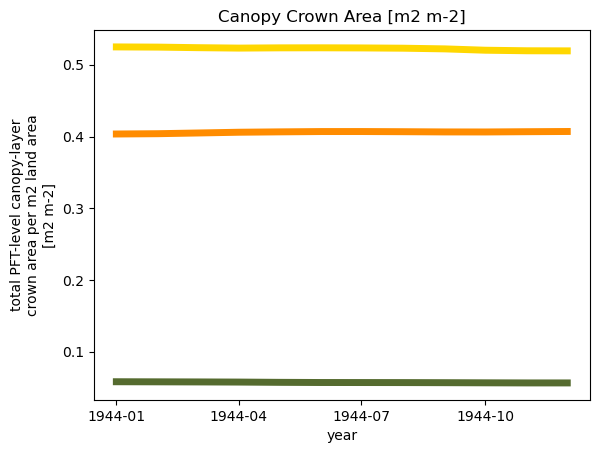

In [32]:
for p in range(n_pfts):
    ds_final_year.FATES_CANOPYCROWNAREA_PF.isel(fates_levpft=p).plot(color = pft_colors[p], linewidth = 5)
    
plt.title("Canopy Crown Area [m2 m-2]")
plt.xlabel("year")

### Crown area (canopy and understory)

Text(0.5, 0, 'year')

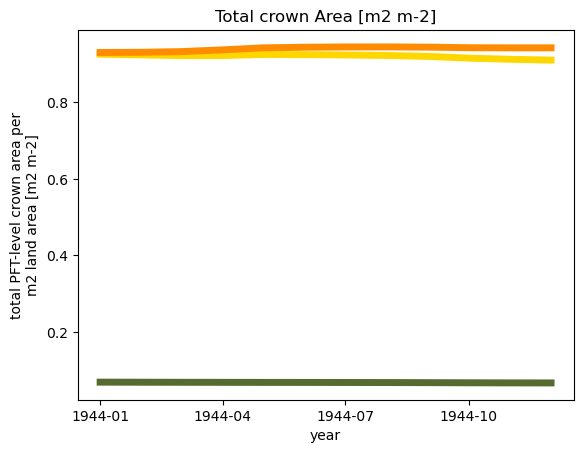

In [33]:
for p in range(n_pfts):
    ds_final_year.FATES_CROWNAREA_PF.isel(fates_levpft=p).plot(color = pft_colors[p], linewidth = 5)
    
plt.title("Total crown Area [m2 m-2]")
plt.xlabel("year")

### Fraction of total crown area in canopy

Text(0.5, 0, 'year')

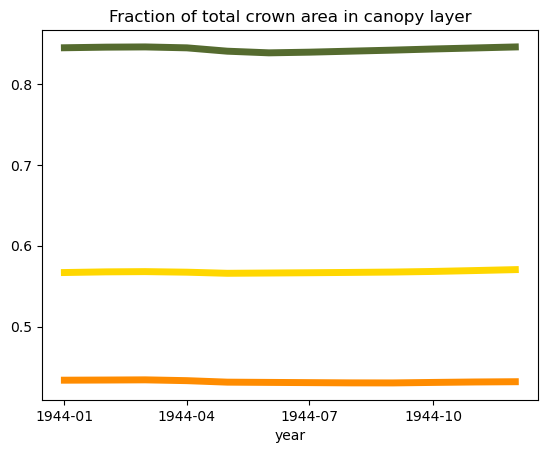

In [34]:
frac_in_canopy = esm_tools.frac_in_canopy(ds_final_year)
for p in range(n_pfts):
    frac_in_canopy.isel(fates_levpft=p).plot(color = pft_colors[p], linewidth = 5)
    
plt.title("Fraction of total crown area in canopy layer")
plt.xlabel("year")

In [36]:
importlib.reload(esm_tools)
importlib.reload(esm_viz)

<module 'esm_viz' from '/glade/u/home/adamhb/Earth-System-Model-Tools/process_output/esm_viz.py'>

### Crown area by patch age

/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


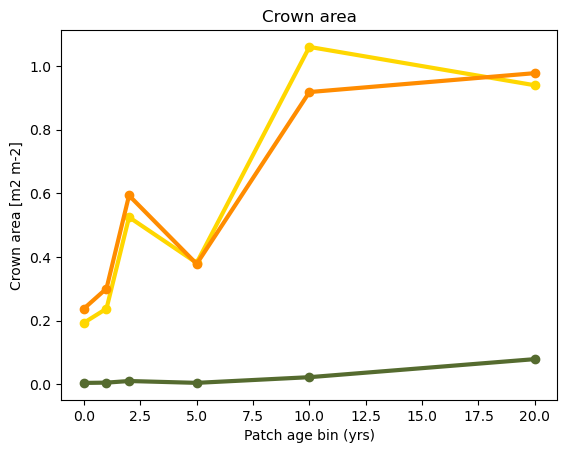

In [37]:
esm_viz.cca_by_patch_age(ds_final_year,
                         n_pfts = n_pfts,
                         pft_colors = pft_colors,
                         pft_names = pft_names,
                         canopy_crown_area = False)

### Canopy crown area by patch age

/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


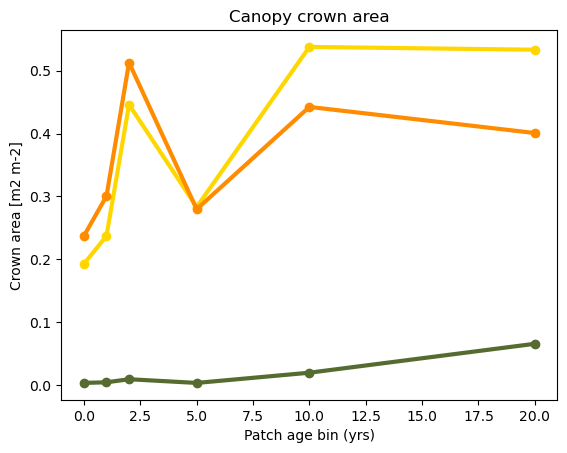

In [38]:
esm_viz.cca_by_patch_age(ds_final_year,n_pfts = n_pfts,
                          pft_colors = pft_colors,
                          pft_names = pft_names,canopy_crown_area = True)

# Last 50 years

## Burned area

In [39]:
print("Mean annual burn fraction:",esm_tools.get_mean_annual_burn_frac(ds,start_date=None,end_date=None))

Mean annual burn fraction: 0.001


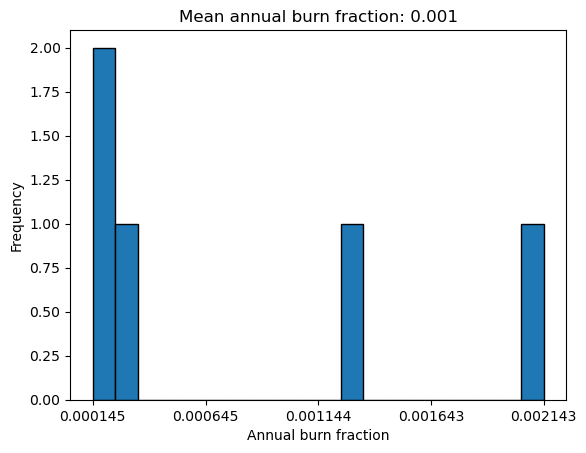

In [40]:
esm_viz.plot_mean_annual_burn_frac(ds,start_date=None,end_date=None)

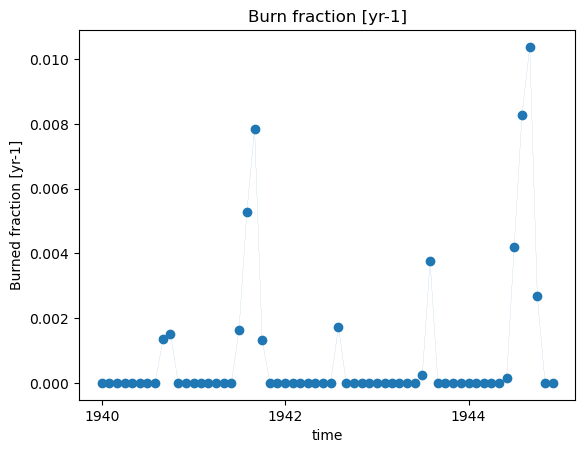

In [41]:
burnfrac = ds.FATES_BURNFRAC  * s_per_yr
burnfrac.plot(linestyle = "--", lw = 0.1, marker = "o")


plt.title('Burn fraction [yr-1]')
plt.ylabel("Burned fraction [yr-1]")
plt.show()

In [ ]:
importlib.reload(esm_tools)
importlib.reload(esm_viz)

# Basal Area

In [ ]:
fig, axes = plt.subplots(ncols=2,nrows=math.ceil(len(scenarios)/2),figsize=(12,10), sharey=True)

for s,ax in zip(range(len(scenarios)),axes.ravel()):
    print(scenarios[s])
    plot_ba(fates_data[s], ax, scenarios[s])
    
plt.tight_layout()
plt.subplots_adjust(hspace=0.5,wspace=0.2)
plt.suptitle('Basal Area ({})'.format(param_set),y = 1.035)

if make_report == True:
    plt.savefig(os.path.join(output_path,"BA.png"))

In [ ]:
fig, axes = plt.subplots(ncols=2,nrows=math.ceil(len(scenarios)/2),figsize=(12,10), sharey=True)

for s,ax in zip(range(len(scenarios)),axes.ravel()):
    print(scenarios[s])
    plot_ba(fates_data[s], ax, scenarios[s])
    
plt.tight_layout()
plt.subplots_adjust(hspace=0.5,wspace=0.2)
plt.suptitle('Basal Area ({})'.format(param_set),y = 1.035)

if make_report == True:
    plt.savefig(os.path.join(output_path,"BA.png"))

In [ ]:
fig, axes = plt.subplots(ncols=1,nrows=1,figsize=(12,10), sharey=True)
ax = fig.axes[0]
plot_ba(ds,ax,"0007")

In [ ]:
list(ds.keys())

In [ ]:
ds.FATES_LAISUN_Z_CLLLPF.isel(fates_levcnlfpf = slice(240,None)).sel(time = slice("1901-01-01","1920-12-13")).sum(dim = "fates_levcnlfpf").plot()

In [ ]:
ds.FATES_BASALAREA_SZPF

In [ ]:
ds.TBOT.sel(time = slice("1910-01-01","1925-12-13")).plot()

### Getting BA for multiple instances

In [ ]:
"conifer-allom-082223_-17e2acb6a_FATES-55794e61", years, fields, inst = "0007",
                               manual_path="/glade/scratch/adamhb/archive/conifer-allom-082223_-17e2acb6a_FATES-55794e61/run"

In [ ]:
instances = []
for i in np.random.randint(1,36,10):
    instances.append((str(i+1).rjust(4, '0')))

In [ ]:
for inst_n in instances:
    years = list(range(1900, 1920))
    ds = multiple_netcdf_to_xarray(sim_root, "conifer-allom-082223_-17e2acb6a_FATES-55794e61", years, fields, inst = inst_n,
                                   manual_path="/glade/scratch/adamhb/archive/conifer-allom-082223_-17e2acb6a_FATES-55794e61/run")
    fig, axes = plt.subplots(ncols=1,nrows=1,figsize=(12,10), sharey=True)
    ax = fig.axes[0]
    plot_ba(ds,ax,inst_n)
    plt.savefig(os.path.join("/glade/u/home/adamhb",f"conifer_allom_test_{inst_n}.png"))
    print("finished",inst_n)

# Benchmarking multiple sites 

In [ ]:
fates_data = []

for i,c in enumerate(cases):
    fates_data.append(multiple_netcdf_to_xarray(sim_root, c, years[i], fields))

# Size class distribution

In [ ]:
#disentangle the multiplexed size class X pft dimension
basal_area = scpf_to_scls_by_pft(ds.FATES_BASALAREA_SZPF, ds)

#get basal area in final time step
basal_area = basal_area.sel(time = "2048-07-01")

fig, axes = plt.subplots(ncols=2,nrows=3,figsize=(7,7))

for p,ax in zip(range(n_pfts),axes.ravel()):
    ba_m2_ha = basal_area.isel(fates_levpft=p) * m2_per_ha
    ba_m2_ha.plot(ax=ax, x = "fates_levscls", marker = "o", lw = 0, 
                                                        color = pft_colors[p], markersize = 7)
    ax.title.set_text('{}'.format(pft_names[p]))
    ax.set_ylabel('BA [m-2 ha-1]')
    

plt.tight_layout()
plt.subplots_adjust(hspace=0.7,wspace=0.4)

In [ ]:


stem_den_scls_pf = scpf_to_scls_by_pft(ds.FATES_NPLANT_SZPF,ds) * m2_per_ha

fig, axes = plt.subplots(ncols=2,nrows=3,figsize=(7,7))

for p,ax in zip(range(n_pfts),axes.ravel()):
    stem_den_scls_pre = stem_den_scls_pf.sel(fates_levscls = slice(10,None)).isel(fates_levpft = p).sel(time = "2048-01-01")
    stem_den_scls_pre.plot(marker = "o", lw = 0.0001, ax = ax, color = pft_colors[p])
    ax.title.set_text('{}'.format(pft_names[p]))
    ax.set_ylabel('Density [N ha-1]')
    
plt.tight_layout()
plt.subplots_adjust(hspace=0.7,wspace=0.4)

# Crown area

In [ ]:
crown_area = appf_to_ap_by_pft(fates_data[s].FATES_CROWNAREA_APPF,fates_data[s])
crown_area

In [ ]:
fates_data[s].FATES_CROWNAREA_APPF

In [ ]:
fig, axes = plt.subplots(ncols=2,nrows=math.ceil(len(scenarios)/2),figsize=(12,10), sharey=True)

for s,ax in zip(range(len(scenarios)),axes.ravel()):
    print(scenarios[s])
    crown_area = appf_to_ap_by_pft(fates_data[s].FATES_CROWNAREA_APPF,fates_data[s])
    for p in range(n_pfts):
        crown_area.sum(axis=2).isel(fates_levpft = p).plot(ax = ax, color = pft_colors[p])
    
plt.tight_layout()
plt.subplots_adjust(hspace=0.5,wspace=0.2)
plt.suptitle('Crown Area ({})'.format(param_set),y = 1.035)

if make_report == True:
    plt.savefig(os.path.join(output_path,"Crown_area.png"))

# Burned Area

In [ ]:
positions = list(range(len(scenarios)))
max_position = np.max(np.array(positions))

fig, ax = plt.subplots()

for x,x_label in enumerate(scenarios):
    
    #add observations
    if x < 1:
        legend_label = "Observations"
    else:
        legend_label = None
    
    #add observations
    ax.scatter(x, burnFrac_obs[x], color='r', label = legend_label)
    ax.plot([x,x], [burnFrac_uncertainty_low[x], burnFrac_uncertainty_high[x]], color = "r")
    
    #add fates prediction
    
    if x < 1:
        legend_label = "FATES"
    else:
        legend_label = None
    
    print(x_label)
    
    ax.scatter(x, 
               get_mean_annual_burn_frac(fates_data[x],None,None), color='b', marker = "^", label = legend_label)
    
ax.set_xticks(positions)
ax.set_xticklabels(scenarios)
ax.set_xlim(-1, max_position + 1)

plt.xticks(rotation=45)
plt.ylabel("Annual burned fraction")
plt.title('Annual burned fraction ({})'.format(param_set))
plt.legend()
if make_report == True:
    plt.savefig(os.path.join(output_path,"Burned_Fraction.png"))
plt.show()

# Percent high severity

In [ ]:
fig, ax = plt.subplots()

for x,x_label in enumerate(scenarios):
    
    #add observations
    if x < 1:
        legend_label = "Observations"
    else:
        legend_label = None
    
    #add observations
    ax.scatter(x, PHS_obs[x], color='r', label = legend_label)
    
    #add fates prediction
    print(x_label)
    
    if x < 1:
        legend_label = "FATES"
    else:
        legend_label = None
    
    ax.scatter(x, 
               get_PHS_conifer(fates_data[x],None,None), color='b', marker = "^", label = legend_label)
    
ax.set_xticks(positions)
ax.set_xticklabels(scenarios)
ax.set_xlim(-1, max_position + 1)

plt.xticks(rotation=45)
plt.ylabel("Percentage high severity")
plt.title('Percentage high severity ({})'.format(param_set))
plt.legend()
if make_report == True:
    plt.savefig(os.path.join(output_path,"PHS.png"))
plt.show()

# Percent of fires above 3500 kW

In [ ]:
fig, ax = plt.subplots()

for x,x_label in enumerate(scenarios):
    
    #add observations
    if x < 1:
        legend_label = "Observations"
    else:
        legend_label = None
    
    #add observations
    ax.scatter(x, PHS_obs[x], color='r', label = legend_label)
    
    #add fates prediction
    print(x_label)
    
    if x < 1:
        legend_label = "FATES"
    else:
        legend_label = None
    
    ax.scatter(x, 
               get_PHS_FLI_thresh(fates_data[x],3500), color='b', marker = "^", label = legend_label)
    
ax.set_xticks(positions)
ax.set_xticklabels(scenarios)
ax.set_xlim(-1, max_position + 1)

plt.xticks(rotation=45)
plt.ylabel("Percentage fires > 3500 kW")
plt.title('Percentage high severity FLI ({})'.format(param_set))
plt.legend()
if make_report == True:
    plt.savefig(os.path.join(output_path,"PHS_3500_kW.png"))
plt.show()

# PFT climate responses

In [ ]:
positions = list(range(len(pft_names)))
max_position = np.max(np.array(positions))


fig, ax = plt.subplots()

for x,x_label in enumerate(pft_names):
    
    if x < 1:
        legend_label = scenarios[climate_response_comparison_indices[0]]
    else:
        legend_label = None
    
    #dry site
    ax.scatter(x, get_frac_pft_level_basal_area(fates_data[climate_response_comparison_indices[0]],x,basal_area_year_climate_comparison,0),
                                                color='black', label = legend_label)
    
    
    
    if x < 1:
        legend_label = scenarios[climate_response_comparison_indices[1]]
    else:
        legend_label = None
    
    ax.scatter(x, get_frac_pft_level_basal_area(fates_data[climate_response_comparison_indices[1]],x,basal_area_year_climate_comparison,0),
                                                color='black', marker = "^",label = legend_label)
    
ax.set_xticks(positions)
ax.set_xticklabels(pft_names)
ax.set_xlim(-1, max_position + 1)

plt.xticks(rotation=45)
plt.ylabel("Fraction of total basal area")
plt.title("PFT climate response ({})".format(param_set))
plt.legend()
if make_report == True:
    plt.savefig(os.path.join(output_path,"climate_response.png"))
plt.show()

# PFT fire responses

In [ ]:
fire_response_comparison_indices[1]

In [ ]:
fig, ax = plt.subplots()

for x,x_label in enumerate(pft_names):
    
    if x < 1:
        legend_label = scenarios[fire_response_comparison_indices[0]]
    else:
        legend_label = None
    
    #Fire Suppression
    ax.scatter(x, get_frac_pft_level_basal_area(fates_data[fire_response_comparison_indices[0]],x,basal_area_year_fire_comparison[0],0),
                                                color='black', label = legend_label)
    
    
    
    if x < 1:
        legend_label = scenarios[fire_response_comparison_indices[1]]
    else:
        legend_label = None
    
    ax.scatter(x, get_frac_pft_level_basal_area(fates_data[fire_response_comparison_indices[1]],x,basal_area_year_fire_comparison[1],0),
                                                color='black', marker = "^",label = legend_label)
    
ax.set_xticks(positions)
ax.set_xticklabels(pft_names)
ax.set_xlim(-1, max_position + 1)

plt.xticks(rotation=45)
plt.ylabel("Fraction of total basal area")
plt.title("PFT response to fire ({})".format(param_set))
plt.legend()
if make_report == True:
    plt.savefig(os.path.join(output_path,"fire_response.png"))
plt.show()

# Post-fire regeneration crown area

In [ ]:
fig, axes = plt.subplots(ncols=2,nrows=math.ceil(len(scenarios)/2),figsize=(12,10))

for s,ax in zip(range(len(scenarios)),axes.ravel()):
    print(scenarios[s])
    cca_by_patch_age(fates_data[s], ax, scenarios[s])
    
plt.tight_layout()
plt.subplots_adjust(hspace=0.5,wspace=0.2)
plt.suptitle('Regeneration ({})'.format(param_set),y = 1.035)

if make_report == True:
    plt.savefig(os.path.join(output_path,"regen.png"))

# Fire analysis

## Fuel load over time among scenarios

In [ ]:
age_by_fuel = agefuel_to_age_by_fuel(fates_data[i].FATES_FUEL_AMOUNT_APFC,fates_data[i])
age_by_fuel.isel(fates_levfuel=2).isel(fates_levage=2).plot()

In [ ]:
plt.rcParams.update({'axes.titlesize': 'large', 'axes.labelsize':'large'})

fig, axes = plt.subplots(ncols=2,nrows=3,figsize=(10,10), sharey = False)

fuel_class_names = ['twig','small branch','large branch','trunk','dead leaves','live grass']

fuel_class_obs = [0.0525,0.192,0.27,0.792,1.32,0.0]

for p,ax in zip(range(6),axes.ravel()):
    for i,s in enumerate(scenarios):
        age_by_fuel = agefuel_to_age_by_fuel(fates_data[i].FATES_FUEL_AMOUNT_APFC,fates_data[i])
        fates_fuel_amount_by_class = age_by_fuel.sum(axis = 2)
        fates_fuel_amount_by_class.isel(fates_levfuel=p).plot(x = "time",
                                                                                                           lw = 2,
                                                                                                           ax = ax,
                                                                                                           label = s,
                                                                                                           color = scenario_colors[i],
                                                                                                           linestyle = scenario_line_styles[i])
        
        ax.axhline(y=fuel_class_obs[p], color='black', linestyle = "dashed")
        ax.set_ylabel("Fuel amount [Kg C m-2]")
        ax.set_title(fuel_class_names[p])
    
plt.tight_layout()
plt.legend()
plt.show()

## Fuel load over patch age among scenarios



The below shows that fuel accumulates very fast on young patches in the scenarios dominated by shrubs.

In [ ]:
age_by_fuel = agefuel_to_age_by_fuel(fates_data[i].FATES_FUEL_AMOUNT_APFC,fates_data[i])
age_by_fuel = age_by_fuel.mean(axis = 0)
mean_patch_area = fates_data[i].FATES_PATCHAREA_AP.mean(axis = 0)
mean_patch_area.values

In [ ]:
age_by_fuel / mean_patch_area

In [ ]:
plt.rcParams.update({'axes.titlesize': 'large', 'axes.labelsize':'large'})

fig, axes = plt.subplots(ncols=2,nrows=3,figsize=(10,10), sharey = False)

fuel_class_names = ['twig','small branch','large branch','trunk','dead leaves','live grass']

for p,ax in zip(range(6),axes.ravel()):
    for i,s in enumerate(scenarios):
        age_by_fuel = agefuel_to_age_by_fuel(fates_data[i].FATES_FUEL_AMOUNT_APFC,fates_data[i])
        age_by_fuel = age_by_fuel.mean(axis = 0)
        mean_patch_area = fates_data[i].FATES_PATCHAREA_AP.mean(axis = 0)
        age_by_fuel_normalized = age_by_fuel / mean_patch_area
        age_by_fuel_normalized.isel(fates_levfuel=p).plot(x = "fates_levage",lw = 2,ax = ax,label = s,color = scenario_colors[i],
                                                                      linestyle = scenario_line_styles[i], marker = "o")
        ax.set_ylabel("Fuel amount [Kg C m-2]")
        ax.set_title(fuel_class_names[p])
    
plt.tight_layout()
plt.legend()
plt.show()

## Fire line intensity

In [ ]:
fig, axes = plt.subplots(ncols=2,nrows=int(len(scenarios)/2),figsize=(10,10), sharey = True)

for s,ax in zip(range(len(scenarios)),axes.ravel()):
    print(scenarios[s])
    aw_fi = get_area_weighed_FLI(fates_data[s])
    aw_fi.plot(ax = ax, marker = "o",linewidth = 0.5,color = scenario_colors[s], linestyle = scenario_line_styles[s])
    ax.set_ylabel("Fire line intensity [kW m-1]")
    ax.set_title(scenarios[s])
    
plt.tight_layout()

## Size-based fire mortality

In [ ]:
fig, axes = plt.subplots(ncols=2,nrows=3,figsize=(10,10), sharey = True)

for p,ax in zip(range(n_pfts),axes.ravel()):
    for i,s in enumerate(scenarios):
        per_capita_fire_mort_by_scls = get_per_capita_fire_mort_by_scls(fates_data[i])
        per_capita_fire_mort_by_scls.mean(axis = 0).isel(fates_levpft = p).plot(x = "fates_levscls", ax = ax,label = scenarios[i],color = scenario_colors[i],
                                                                      linestyle = scenario_line_styles[i], marker = "o")

        ax.set_ylabel("[N per capita yr -1]")
        ax.set_title("{} fire mort.".format(pft_names[p]))
        if p == 0:
            ax.legend()


plt.tight_layout()
plt.show()

# Functions

In [ ]:
def preprocess(ds, fields):
    '''Selects the variables we want to read in 
       Drops lndgrid because we are on a single point'''
    
    return ds[fields].sel(lndgrid=0)


def fix_time(ds):
    '''Does a quick fix to adjust time vector for monthly data'''
    nmonths = len(ds.time)
    yr0 = ds['time.year'][0].values
    ds['time'] = xr.cftime_range(str(yr0), periods=nmonths, freq='MS')

    return ds

def multiple_netcdf_to_xarray(path, case, years, fields, inst = None, manual_path = None):
    
    if case == None:
        return None
    
    months = list(range(1, 13, 1))

    # build a list of file names based on the year and month
    
    if inst == None:
    
        file_names = [f"{case}.clm2.h0.{str(year)}-{str(month).rjust(2, '0')}.nc"
                  for year in years for month in months]
    else:
        file_names = [f"{case}.clm2_{inst}.h0.{str(year)}-{str(month).rjust(2, '0')}.nc"
                  for year in years for month in months]

    if manual_path != None:
        full_paths = [os.path.join(manual_path, fname) for fname in file_names]
    
    else:
    # create their full path
        full_paths = [os.path.join(path, case, 'lnd/hist', fname) for fname in file_names]

    # open the dataset -- this may take a bit of time
    ds = fix_time(xr.open_mfdataset(full_paths, decode_times=True,
                                    preprocess=functools.partial(preprocess, fields=fields)))

    print('-- your data have been read in -- ')
    
    return(ds)

def scpf_to_scls_by_pft(scpf_var, dataset):
    """function to reshape a fates multiplexed size and pft-indexed variable to one indexed by size class and pft
    first argument should be an xarray DataArray that has the FATES SCPF dimension
    second argument should be an xarray Dataset that has the FATES SCLS dimension 
    (possibly the dataset encompassing the dataarray being transformed)
    returns an Xarray DataArray with the size and pft dimensions disentangled"""
    n_scls = len(dataset.fates_levscls)
    ds_out = (scpf_var.rolling(fates_levscpf=n_scls, center=False)
            .construct("fates_levscls")
            .isel(fates_levscpf=slice(n_scls-1, None, n_scls))
            .rename({'fates_levscpf':'fates_levpft'})
            .assign_coords({'fates_levscls':dataset.fates_levscls})
            .assign_coords({'fates_levpft':dataset.fates_levpft}))
    ds_out.attrs['long_name'] = scpf_var.attrs['long_name']
    ds_out.attrs['units'] = scpf_var.attrs['units']
    return(ds_out)


def appf_to_ap_by_pft(appf_var, dataset):
    """function to reshape a fates multiplexed size and pft-indexed variable to one indexed by size class and pft
    first argument should be an xarray DataArray that has the FATES SCPF dimension
    second argument should be an xarray Dataset that has the FATES SCLS dimension 
    (possibly the dataset encompassing the dataarray being transformed)
    returns an Xarray DataArray with the size and pft dimensions disentangled"""
    n_ap = len(dataset.fates_levage)
    ds_out = (appf_var.rolling(fates_levagepft=n_ap, center=False)
            .construct("fates_levage")
            .isel(fates_levagepft=slice(n_ap-1, None, n_ap))
            .rename({'fates_levagepft':'fates_levpft'})
            .assign_coords({'fates_levage':dataset.fates_levage})
            .assign_coords({'fates_levpft':dataset.fates_levpft}))
    #ds_out.attrs['long_name'] = scpf_var.attrs['long_name']
    #ds_out.attrs['units'] = scpf_var.attrs['units']
    return(ds_out)


def getNBase(xarr):
    nyears = len(np.unique(pd.to_datetime(xarr.time).year))
    nbase = max(nyears // n_ticks, 1)
    return(nbase)


def plot_appf(xarr, xds, n_pfts, sup_title, ylabel, output_path):

    xarr = appf_to_ap_by_pft(xarr, xds)

    n_age = len(xds.fates_levage)

    ncol,nrow = get_n_subplots(n_age)

    #nbase = getNBase(xarr) * 2

    fig, axes = plt.subplots(ncols=ncol,nrows=nrow,figsize=(12,10))

    for age,ax in zip(range(n_age),axes.ravel()):

         cca = xarr.isel(fates_levage = age) / xds.FATES_PATCHAREA_AP.isel(fates_levage = age)

         for p in range(n_pfts):
             cca.isel(fates_levpft=p).plot(x = "time",
                      color = pft_colors[p],lw = 3,add_legend = True,
                      label = pft_names[p], ax = ax)

             #plt.legend()
         ax.set_title('{} yr old patches'.format(xds.fates_levage.values[age]))
         ax.set_ylabel(ylabel,fontsize = int(12 * 0.75))
         ax.xaxis.set_major_formatter(DateFormatter('%Y'))
         #ax.xaxis.set_major_locator(mdates.YearLocator(base=nbase))

    plt.tight_layout()
    plt.subplots_adjust(hspace=1,wspace=0.2)
    fig.suptitle(sup_title, fontsize=12,y=0.99)


def make_output_path(base,case):
    
    directory = os.path.join(base,case)

    # Create the directory if it doesn't already exist
    if not os.path.exists(directory):
        os.makedirs(directory)
        print("Directory created successfully:",directory)
    else:
        print("Directory already exists:",directory)
        
    return directory


def get_ignition_success(ds, ignition_density):
    successful_ignitions = ds.FATES_IGNITIONS.values.mean() * s_per_yr * m2_per_km2
    ignition_success_rate = successful_ignitions / ignition_density
    return np.round(ignition_success_rate,3)


def get_mean_annual_burn_frac(ds,start_date,end_date):
    burnfrac = ds.FATES_BURNFRAC.sel(time = slice(start_date,end_date)).values.mean()  * s_per_yr
    return np.round(burnfrac,3)

def plot_mean_annual_burn_frac(ds,case):
    burnfrac = ds.FATES_BURNFRAC  * s_per_yr
    total_mean_annual_burnfrac = get_mean_annual_burn_frac(ds)

    annual_mean_burnfrac = burnfrac.groupby('time.year').mean(dim='time').values
    title = f"Mean annual burn fraction: {np.round(total_mean_annual_burnfrac,3)}"
    # Create a histogram of the distribution of annual means
    plt.hist(annual_mean_burnfrac, bins=20, edgecolor='black')
    plt.xlabel('Annual burn fraction')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.savefig(output_path + "/" + case + "_" + title.replace(" ","-") + ".png")
    plt.clf()

    
def get_awfi(ds):
    aw_fi = ds.FATES_FIRE_INTENSITY_BURNFRAC / (ds.FATES_BURNFRAC * s_per_day) / 1000
    return aw_fi

def plot_area_weighted_fire_intensity(ds,case):
    aw_fi = get_awfi(ds)
    aw_fi.plot(marker = "o",linewidth = 0.5)
    plt.ylabel("Fire line intensity [kW m-1]")
    title = "Fire Intensity"
    plt.title(title)
    plt.savefig(output_path + "/" + case + "_" + title.replace(" ","-") + ".png")
    plt.clf()

def get_n_fire_months(ds):
    aw_fi = get_awfi(ds)
    n_months = len(aw_fi.values)
    aw_fi = aw_fi.where(~np.isnan(aw_fi), 0)
    n_fire_months_boolean = aw_fi > 0
    n_fire_months = np.sum(n_fire_months_boolean.values)
    return n_fire_months

def get_PHS_FLI_thresh(ds,FLI_thresh):
    
    aw_fi = get_awfi(ds)
    n_months_greater_than_thresh_boolean = aw_fi > FLI_thresh
    n_months_greater_than_thresh = np.sum(n_months_greater_than_thresh_boolean.values)
    n_fire_months = get_n_fire_months(ds)
    PHS = n_months_greater_than_thresh / n_fire_months * 100
    return PHS

    
def get_PHS(ds,start_date,end_date):
    ds = ds.sel(time = slice(start_date,end_date))
    
    n_fire_months = get_n_fire_months(ds)
    
    #disentangle the multiplexed size class X pft dimension
    mort_fire_by_pft_and_scls = scpf_to_scls_by_pft(ds.FATES_MORTALITY_FIRE_SZPF, ds)

    #get the monthly burned area to calculate mortality rates just on the burned area
    monthly_burnfrac = ds.FATES_BURNFRAC  * s_per_month

    #sum across size classes to get pft-level mort from fire
    mort_fire_by_pft = mort_fire_by_pft_and_scls.sum(axis=2)

    #per capita mort per month per unit area that burned
    mort_fire_per_capita_per_month_per_burned_area = mort_fire_by_pft / ds.FATES_NPLANT_PF / months_per_yr / monthly_burnfrac
    greater_than_95_mort_bool = mort_fire_per_capita_per_month_per_burned_area.sel(fates_levpft = slice(1,3)).mean(axis = 1) > 0.95
    greater_than_95_mort = np.sum(greater_than_95_mort_bool.values)
    #print("conifer mort greater_than_95_mort",greater_than_95_mort)

    greater_than_95_mort_bool_all_pfts = mort_fire_per_capita_per_month_per_burned_area.mean(axis = 1) > 0.95
    greater_than_95_mort_all_pfts = np.sum(greater_than_95_mort_bool_all_pfts.values)

    frac_greater_than_95_mort = greater_than_95_mort / n_fire_months
    #print("Conifer PHS:",np.round(frac_greater_than_95_mort,3))

    frac_greater_than_95_mort_all_pfts = greater_than_95_mort_all_pfts / n_fire_months
    #print("PHS:",np.round(frac_greater_than_95_mort_all_pfts,3))
    
    return np.round(frac_greater_than_95_mort_all_pfts,3) * 100


def get_PHS_conifer(ds,start_date,end_date):
    ds = ds.sel(time = slice(start_date,end_date))
    
    n_fire_months = get_n_fire_months(ds)
    
    #disentangle the multiplexed size class X pft dimension
    mort_fire_by_pft_and_scls = scpf_to_scls_by_pft(ds.FATES_MORTALITY_FIRE_SZPF, ds)

    #get the monthly burned area to calculate mortality rates just on the burned area
    monthly_burnfrac = ds.FATES_BURNFRAC  * s_per_month

    #sum across size classes to get pft-level mort from fire
    mort_fire_by_pft = mort_fire_by_pft_and_scls.sum(axis=2)

    #per capita mort per month per unit area that burned
    mort_fire_per_capita_per_month_per_burned_area = mort_fire_by_pft / ds.FATES_NPLANT_PF / months_per_yr / monthly_burnfrac
    greater_than_95_mort_bool = mort_fire_per_capita_per_month_per_burned_area.sel(fates_levpft = slice(1,3)).mean(axis = 1) > 0.95
    greater_than_95_mort = np.sum(greater_than_95_mort_bool.values)
    #print("conifer mort greater_than_95_mort",greater_than_95_mort)

    greater_than_95_mort_bool_all_pfts = mort_fire_per_capita_per_month_per_burned_area.mean(axis = 1) > 0.95
    greater_than_95_mort_all_pfts = np.sum(greater_than_95_mort_bool_all_pfts.values)

    frac_greater_than_95_mort = greater_than_95_mort / n_fire_months
    #print("Conifer PHS:",np.round(frac_greater_than_95_mort,3))

    frac_greater_than_95_mort_all_pfts = greater_than_95_mort_all_pfts / n_fire_months
    #print("PHS:",np.round(frac_greater_than_95_mort_all_pfts,3))
    
    return np.round(frac_greater_than_95_mort,3) * 100


def get_frac_pft_level_basal_area(ds,pft_i,date,dbh_min = 0):
    basal_area = scpf_to_scls_by_pft(ds.FATES_BASALAREA_SZPF, ds) 
    basal_area = basal_area.sel(fates_levscls = slice(dbh_min,None)).sel(time = date)
    total_basal_area = basal_area.sum(axis=1).sum(axis = 0)
    basal_area_pf = basal_area.isel(fates_levpft = pft_i).sum(axis = 0)
    frac_ba = basal_area_pf.values / total_basal_area.values
    return frac_ba


def write_fire_report(ds,ignition_density,output_path,case):
    
    original_stdout = sys.stdout
    
    mean_burn_frac = get_mean_annual_burn_frac(ds)
    
    with open(output_path + '/' + 'fire_report.txt', 'w') as f:
        sys.stdout = f # Change the standard output to the file we created.
        
        print("case:",case)
        print("Mean annual burn frac:",mean_burn_frac)
        print("Mean FRI:",1 / mean_burn_frac)
        print('PHS (> 95% mort):',get_PHS(ds))
        print('PHS (> 3500 kW m-1):',get_PHS_FLI_thresh(ds,FLI_thresh))
        print('Ignition success:',get_ignition_success(ds, ignition_density))
        
        sys.stdout = original_stdout
        
        
def plus_minus_20_pct(number):
    plus_20 = number * 1.2
    minus_20 = number * 0.8
    return [plus_20,minus_20]



def check_fire_regime(ds):

    FLI_threshold = 3500

    burnfrac = ds.FATES_BURNFRAC  * s_per_yr
    print("Mean annual burn fraction",burnfrac.values.mean())
    fri = 1 / (ds.FATES_BURNFRAC.values.mean() * s_per_yr)
    print("Mean fire return interval (yrs):",fri)

    aw_fi = ds.FATES_FIRE_INTENSITY_BURNFRAC / (ds.FATES_BURNFRAC * s_per_day) / 1000
    n_months = len(aw_fi.values)
    print("n months",n_months)
    aw_fi = aw_fi.where(~np.isnan(aw_fi), 0)
    n_fire_months_boolean = aw_fi > 0
    n_fire_months = np.sum(n_fire_months_boolean.values)
    print("n fire months", n_fire_months)
    n_months_greater_than_thresh_boolean = aw_fi > FLI_threshold
    n_months_greater_than_thresh = np.sum(n_months_greater_than_thresh_boolean.values)
    print("n months > threshold",n_months_greater_than_thresh)

    print("Fraction of fire months that burned hotter than X",n_months_greater_than_thresh / n_fire_months)

    #disentangle the multiplexed size class X pft dimension
    mort_fire_by_pft_and_scls = scpf_to_scls_by_pft(ds.FATES_MORTALITY_FIRE_SZPF, ds)

    #get the monthly burned area to calculate mortality rates just on the burned area
    monthly_burnfrac = ds.FATES_BURNFRAC  * s_per_month

    #sum across size classes to get pft-level mort from fire
    mort_fire_by_pft = mort_fire_by_pft_and_scls.sum(axis=2)

    #per capita mort per month per unit area that burned
    mort_fire_per_capita_per_month_per_burned_area = mort_fire_by_pft / ds.FATES_NPLANT_PF / months_per_yr / monthly_burnfrac
    greater_than_95_mort_bool = mort_fire_per_capita_per_month_per_burned_area.sel(fates_levpft = slice(1,3)).mean(axis = 1) > 0.95
    greater_than_95_mort = np.sum(greater_than_95_mort_bool.values)
    print("conifer mort greater_than_95_mort",greater_than_95_mort)

    greater_than_95_mort_bool_all_pfts = mort_fire_per_capita_per_month_per_burned_area.mean(axis = 1) > 0.95
    greater_than_95_mort_all_pfts = np.sum(greater_than_95_mort_bool_all_pfts.values)


    frac_greater_than_95_mort = greater_than_95_mort / n_fire_months
    print("frac_greater_than_95_mort",frac_greater_than_95_mort)

    frac_greater_than_95_mort_all_pfts = greater_than_95_mort_all_pfts / n_fire_months
    print("frac_greater_than_95_mort_all_pfts",frac_greater_than_95_mort_all_pfts)
    
def plot_ba(ds,ax,title):
        #disentangle the multiplexed size class X pft dimension
        basal_area = scpf_to_scls_by_pft(ds.FATES_BASALAREA_SZPF, ds)

        #sum across size classes to get pft-level ba
        basal_area_pf = basal_area.sum(axis=2)

        #plot pft-level basal area over time
        for p in range(n_pfts):
            ba_per_ha = basal_area_pf.isel(fates_levpft=p) * m2_per_ha
            ba_per_ha.plot(x = "time", color = pft_colors[p],lw = 5, add_legend = True, marker = "o", ax = ax)

        ax.set_title(title)
        ax.set_ylabel('BA [m-2 ha-1]', fontsize=12)
        
        
    
    
def getFullFilePaths(case,start_year,end_year):
    
    years = list(range(int(start_year), int(end_year))) 
    months = list(range(1, 13, 1)) 
    file_names = [f"{case}.clm2.h0.{str(year)}-{str(month).rjust(2, '0')}.nc"
              for year in years for month in months]

    full_paths = [os.path.join(archive_path, case, 'lnd/hist', fname) for fname in file_names]
    return full_paths


def preprocess(ds, fields):
    '''Selects the variables we want to read in 
       Drops lndgrid because we are on a single point'''

    return ds[fields].sel(lndgrid=0)


def fix_time(ds):
    '''Does a quick fix to adjust time vector for monthly data'''
    nmonths = len(ds.time)
    yr0 = ds['time.year'][0].values
    #ds['time'] = xr.cftime_range(str(yr0), periods=nmonths, freq='MS')
    ds['time'] = pd.date_range(start=str(yr0),periods=nmonths,freq="MS")
    return ds


def scpf_to_scls_by_pft(scpf_var, dataset):
    """function to reshape a fates multiplexed size and pft-indexed variable to one indexed by size class and pft
    first argument should be an xarray DataArray that has the FATES SCPF dimension
    second argument should be an xarray Dataset that has the FATES SCLS dimension 
    (possibly the dataset encompassing the dataarray being transformed)
    returns an Xarray DataArray with the size and pft dimensions disentangled"""
    n_scls = len(dataset.fates_levscls)
    ds_out = (scpf_var.rolling(fates_levscpf=n_scls, center=False)
            .construct("fates_levscls")
            .isel(fates_levscpf=slice(n_scls-1, None, n_scls))
            .rename({'fates_levscpf':'fates_levpft'})
            .assign_coords({'fates_levscls':dataset.fates_levscls})
            .assign_coords({'fates_levpft':dataset.fates_levpft}))
    #ds_out.attrs['long_name'] = scpf_var.attrs['long_name']
    #ds_out.attrs['units'] = scpf_var.attrs['units']
    return(ds_out)

def agefuel_to_age_by_fuel(agefuel_var, dataset):
    n_age = len(dataset.fates_levage)
    ds_out = (agefuel_var.rolling(fates_levagefuel = n_age, center=False).construct("fates_levage")
          .isel(fates_levagefuel=slice(n_age-1, None, n_age))
          .rename({'fates_levagefuel':'fates_levfuel'})
          .assign_coords({'fates_levage':dataset.fates_levage})
          .assign_coords({'fates_levfuel':np.array([1,2,3,4,5,6])}))
    return ds_out
    #ds_out.attrs['long_name'] = agefuel_var['long_name']
    #ds_out.attrs['units'] = agefuel_var['units']


def appf_to_ap_by_pft(appf_var, dataset):
    """function to reshape a fates multiplexed size and pft-indexed variable to one indexed by size class and pft
    first argument should be an xarray DataArray that has the FATES SCPF dimension
    second argument should be an xarray Dataset that has the FATES SCLS dimension 
    (possibly the dataset encompassing the dataarray being transformed)
    returns an Xarray DataArray with the size and pft dimensions disentangled"""
    n_ap = len(dataset.fates_levage)
    ds_out = (appf_var.rolling(fates_levagepft=n_ap, center=False)
            .construct("fates_levage")
            .isel(fates_levagepft=slice(n_ap-1, None, n_ap))
            .rename({'fates_levagepft':'fates_levpft'})
            .assign_coords({'fates_levage':dataset.fates_levage})
            .assign_coords({'fates_levpft':dataset.fates_levpft}))
    #ds_out.attrs['long_name'] = scpf_var.attrs['long_name']
    #ds_out.attrs['units'] = scpf_var.attrs['units']
    return(ds_out)

def get_n_subplots(n_pfts): 
 
    if (n_pfts % 2 == 0) | (n_pfts == 1): 
        n_subplots = n_pfts 
    else: 
        n_subplots = n_pfts + 1

    if n_subplots == 1:
        ncol = 1
        nrow = 1

    else:
        ncol = 2
        nrow = n_subplots / ncol

    return (ncol,int(nrow))

def per_capita_rate(xarr,xds,unit_conversion):
    
    xarr = xarr * unit_conversion
    
    if xarr.dims == ('time', 'fates_levscpf'):
        xarr = scpf_to_scls_by_pft(xarr, xds)
        xarr = xarr.sum(axis=2) #sum across size classes
        
    xarr_per_cap = xarr / xds.FATES_NPLANT_PF
    
    return(xarr_per_cap)


def get_rate_table(xarr,xds,var_title,indices,index_title):
    
    if xarr.dims == ('time', 'fates_levage'):
        xarr = xarr.isel(time = slice(-12,-1))
        series = pd.DataFrame(xarr.mean(axis = 0).values,
                     index=xds.fates_levage.values)

    if xarr.dims == ('time', 'fates_levagepft'):
        xarr = appf_to_ap_by_pft(xarr,xds)
        xarr = xarr / xds.FATES_PATCHAREA_AP
        series = pd.DataFrame(xarr.mean(axis = 0).values,
                     index = indices, columns=xds.fates_levage.values)
        series.loc["Total"] = series.sum()
        tab = tabulate(series, headers="keys", tablefmt="psql")
        return(tab)

    if xarr.dims == ('time', 'levgrnd'):
        grnd_depths = xds.levgrnd.values[indices]
        xarr = xarr.isel(levgrnd = indices).isel(time = slice(12,-1)) * MPa_per_mmh2o
        series = pd.DataFrame(xarr.mean(axis = 0).values,
                          index = grnd_depths).sort_values(by = 0, ascending=True).reset_index()
    else:
        series = pd.DataFrame(xarr.mean(axis = 0).values,
                          index = indices).sort_values(by = 0, ascending=False).reset_index()
    
    my_dict = {index_title:list(series.iloc[:,0]), var_title:list(series.iloc[:,1])}
    my_df = pd.DataFrame.from_dict(my_dict).set_index(index_title)
    tab = tabulate(my_df, headers='keys', tablefmt='psql')
    return(tab)

def weighted_avg_par(par_stream,frac_in_canopy):
    par_z = (par_stream.isel(fates_levcnlf = 0) * frac_in_canopy) +\
    (par_stream.isel(fates_levcnlf = 30) * (1 - frac_in_canopy))
    return(par_z)


def frac_in_canopy(xds):
    return(xds.FATES_CANOPYCROWNAREA_PF / xds.FATES_CROWNAREA_PF)

def incident_par(xds):
    f = frac_in_canopy(xds)

    par_z_dir = weighted_avg_par(xds.FATES_PARPROF_DIR_CLLL, f)
    par_z_dif = weighted_avg_par(xds.FATES_PARPROF_DIF_CLLL, f)
    par_total = par_z_dir + par_z_dif

    return(par_total.rolling(time=12, center=True).mean())

def cca_by_patch_age(ds,ax,title):

    canopy_crown_area_by_patch_age = appf_to_ap_by_pft(ds.FATES_CROWNAREA_APPF, ds)

    canopy_crown_area_by_patch_age = canopy_crown_area_by_patch_age / ds.FATES_PATCHAREA_AP

    for p in range(n_pfts):
        canopy_crown_area_by_patch_age.isel(fates_levpft = p).mean(axis = 0).plot(x = "fates_levage",color = pft_colors[p], linewidth = 3, ax = ax, marker = "o")

    ax.set_title(title)
    ax.set_xlabel("Patch age bin (yrs)")
    ax.set_ylabel("Total crown area [m2 m-2]")

    
def is_xarray_dataset(obj):
    return isinstance(obj, xr.Dataset)

def filter_data(ds,start,stop):
    if is_xarray_dataset(ds):
        return ds.sel(time = slice(start, stop))
    else:  
        return None
    
    
def agefuel_to_age_by_fuel(agefuel_var, dataset): 
    n_age = len(dataset.fates_levage)
    ds_out = (agefuel_var.rolling(fates_levagefuel = n_age, center=False).construct("fates_levage")
          .isel(fates_levagefuel=slice(n_age-1, None, n_age))
          .rename({'fates_levagefuel':'fates_levfuel'})
          .assign_coords({'fates_levage':dataset.fates_levage})
          .assign_coords({'fates_levfuel':np.array([1,2,3,4,5,6])}))
    return ds_out
    #ds_out.attrs['long_name'] = agefuel_var['long_name']
    #ds_out.attrs['units'] = agefuel_var['units']

def get_area_weighed_FLI(ds):    
    return (ds.FATES_FIRE_INTENSITY_BURNFRAC / (ds.FATES_BURNFRAC * s_per_day) / 1000)


def get_per_capita_fire_mort_by_scls(ds):
    mort_fire_by_pft_and_scls = scpf_to_scls_by_pft(ds.FATES_MORTALITY_FIRE_SZPF, ds)
    nplant_by_pft_scls = scpf_to_scls_by_pft(ds.FATES_NPLANT_SZPF, ds)
    return(mort_fire_by_pft_and_scls / nplant_by_pft_scls)